# Gene annotation
In this section, we use COG annotations of genes (generated by prokka) to determine the amount of genes for different functions in three different categories of species: free-living, symbiotic with complete genomes and symbiotic with incomplete genomes. All free-living species sampled had complete genomes, so no subdivision was necessary for those.

First, we pre-process the output of prokka (to be specific, the `.gff` files): 
```sh
mkdir genes
cd genes

for f in ../prokka/prokka_*; do \
grep --color=never -e "COG" $f/`basename ${f/prokka_/}`.gff | cut -f9 > `basename ${f/prokka_/}`; 
done

find . -type f | perl -pe 'print $_; s/_\d{9}_\d//' | xargs -d "\n" -n2 mv
find . -type f | perl -pe 'print $_; s/_GC.//' | xargs -d "\n" -n2 mv
```
These commands get the attribute lists from the `.gff` files, and rename the files to just be the species names.
Then, the following script gets the COG annotations for each species, and counts the number of genes in each category for each species.

Individual counts per gene category per species
                              Species    J  A    K    L  B   D  Y   V    T  \
1               Dickeya_dadantii_XJ12  220  1  171  115  0  41  0  61  138   
2           Doolittlea_endobia_DEMHIR  135  1   26   40  0  18  0   7   18   
3           Gullanella_endobia_GEFVIR  134  1   19   40  0  15  0   3    8   
4              Mikella_endobia_mEPMAR  129  0   15   37  0   2  0   2    3   
5                   Moranella_endobia  132  1   19   37  0  14  0   5    6   
6   Pectobacterium_cacticida_CFBP3628  213  1  141  114  0  39  0  58  123   
7        Sodalis_endolongispinus_SOD1  227  1  129  112  0  39  0  63  108   
8      Sodalis_glossinidius_morsitans  218  1  112  122  0  40  0  46   92   
9                  Sodalis_ligni_dw23  221  1  238  129  0  44  0  65  132   
10          Sodalis_pierantonius_SOPE  227  1  118  128  0  37  0  48   88   
11           Sodalis_praecaptivus_HS1  222  1  197  107  0  39  0  57  121   
12              

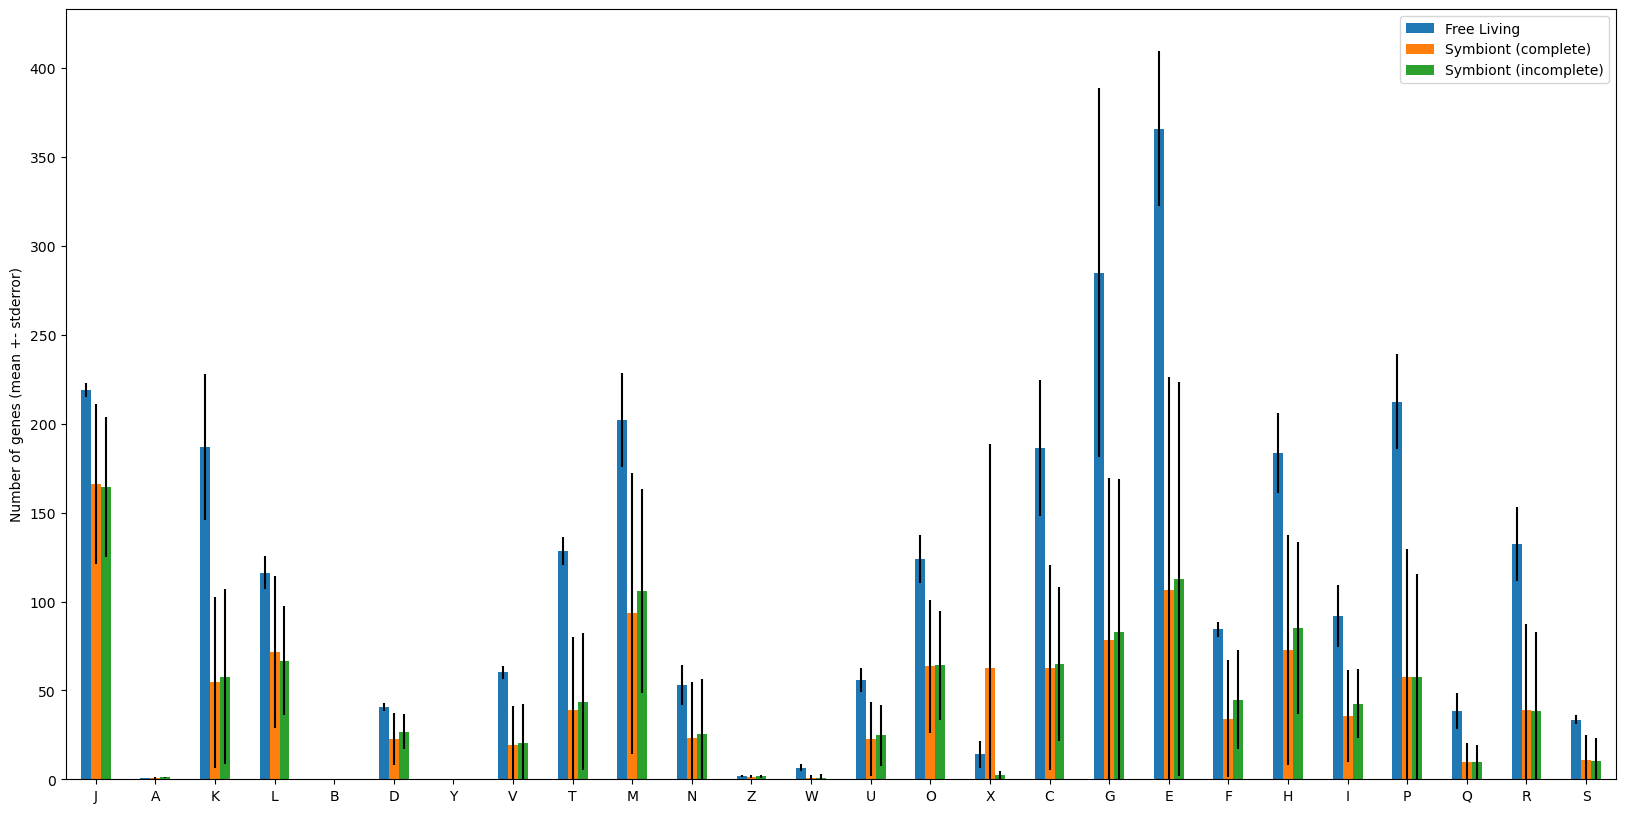

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Import the species table & info
# This is only used to determine whether a species is free-living, and whether it's genome is complete
species_df = pd.read_table("data/gtotree/Genomes_summary_info.tsv")
species_df["is_complete"] = ["Yes","No","Yes","Yes","Yes","Yes","No","Yes","Yes","Yes","Yes","No","Yes","No","No","No","No"]
species_df["is_endosymb"] = ["No","Yes","Yes","Yes","Yes","No","Yes","Yes","No","Yes","No","Yes","Yes","Yes","Yes","Yes","Yes"]

# Make sure the species names are the same as the filenames
species_df["assembly_id"] = species_df["assembly_id"].apply(lambda name: '_'.join(name.split("_")[:-2]))

# Import the COG annotations into a dataframe
cog = pd.read_table("data/functional_information/cog-20.def.tab", names=["ID", "CATEGORY", "NAME", "SYMBOL", "PATHWAYS", "PUBMED", "PDB"], encoding="latin")

# Import the COG category descriptions into a dataframe
cog_cats = pd.read_table("data/functional_information/fun-20.tab", names=["CATEGORY", "??", "CATEGORY_DESCRIPTION"])

# Import the attributes from the gff files into a dataframe
data = {}
species = os.listdir("genes")

# Iterate through each species
# I know specy isn't the right singular of species, but otherwise the variables would be called the same
for specy in species:
        i = 0
        with open("genes/"+specy, "r") as file:
                for line in file:
                        attrs_linked = line.strip().split(";")
                        attrs = [["Species",specy]] + [i.split("=") for i in attrs_linked]
                        had_keys = []
                        for keyval in attrs:
                                if keyval[0] == "db_xref":
                                        # The COG values should be split up a bit more to make life easier later on
                                        keyval[0] = "cog_id"
                                        keyval[1] = keyval[1].split(":")[1]
                                if keyval[0] in data:
                                        # There is already a column for this key, so just append the value
                                        data[keyval[0]].append(keyval[1])
                                else:
                                        # There isn't a column for this key yet, so create one and fill it up with empty strings
                                        # This makes sure the indexing keeps working
                                        data[keyval[0]] = [keyval[1] if j==i else "" for j in range(i+1)]
                                had_keys.append(keyval[0])
                        for key in list(set(data.keys()).difference(had_keys)):
                                # If a previously used key didn't appear in this line, add an empty string to keep indexing working
                                data[key].append("")
                        i+=1

# Turn the dictionary into a dataframe
genes = pd.DataFrame.from_dict(data)

# Add the COG annotations to the gff annotations
genes = genes.join(cog.set_index("ID"), on="cog_id")
#print(genes)

# Count the number of genes in each COG category for each species
# I'm sure there must be a prettier way to do this, but it seems to work
categories = list(cog_cats["CATEGORY"])
columns = ["Species"] + categories
counts = {}
for i in columns:
        counts[i] = [0]
counts = pd.DataFrame.from_dict(counts)

def get_gene_category_counts(species):
        counts = {}
        for i in columns:
                counts[i] = [0]

        counts["Species"] = species
        for index, row in genes.loc[genes['Species'] == species].iterrows():
                for category in row["CATEGORY"]:
                        counts[category][0] += 1
        return pd.DataFrame.from_dict(counts)

for specy in species:
        count = get_gene_category_counts(specy)
        counts = pd.concat([counts, count], ignore_index=True)

counts = counts.drop(0)

counts = counts.join(species_df[["assembly_id","is_complete","is_endosymb"]].set_index('assembly_id'), on='Species')
# Now counts is a dataframe with a row per species, 
# with columns for the amount of genes in a given COG category, and whether they are complete and/or endosymbiotic

print("Individual counts per gene category per species")
print(counts)


# Get the mean and stderr of all of the gene counts in the different categories
free_living_mean = counts.loc[counts['is_endosymb'] == "No", categories].mean().to_frame(name="Free Living")
symbiont_complete_mean = counts.loc[(counts['is_endosymb'] == "Yes") & (counts['is_complete'] == "Yes"), categories].mean().to_frame(name="Symbiont (complete)")
symbiont_incomplete_mean = counts.loc[(counts['is_endosymb'] == "Yes") & (counts['is_complete'] == "No"), categories].mean().to_frame(name="Symbiont (incomplete)")
mean_counts = free_living_mean.join(symbiont_complete_mean.join(symbiont_incomplete_mean))

free_living_std = counts.loc[counts['is_endosymb'] == "No", categories].std().to_frame(name="Free Living")
symbiont_complete_std = counts.loc[(counts['is_endosymb'] == "Yes") & (counts['is_complete'] == "Yes"), categories].std().to_frame(name="Symbiont (complete)")
symbiont_incomplete_std = counts.loc[(counts['is_endosymb'] == "Yes") & (counts['is_complete'] == "No"), categories].std().to_frame(name="Symbiont (incomplete)")
std_counts = free_living_std.join(symbiont_complete_std.join(symbiont_incomplete_std))

# Output everything
print("\nMean values per gene category per species category")
print(mean_counts)
print("\nStandard error values per gene category per species category")
print(std_counts)
mean_counts.plot(kind='bar', yerr=std_counts, rot=0, figsize=(20,10))
plt.ylabel("Number of genes (mean +- stderror)")


print("\nCategory abbreviations and full names")
print(cog_cats[["CATEGORY","CATEGORY_DESCRIPTION"]])

plt.ylim(bottom=0)
plt.show()


It isn't the prettiest graph yet; It's kind of cramped and some error bars extend below the axis, which can't be very good.
No genes are found relating to chromatin structure and dynamics (B) or nuclear structure (Y), which makes sense given we are looking at bacteria. 
Only a few genes related to RNA processing & modification (A), the cytoskeleton (Z) and extracellular structures (W) are found. It would be interesting to look at which genes this precisely are, and see if that tells us anything.
For the rest, the free-living species consistently have more genes than the symbiotic species in each category, with the exception of genes relating to the mobilome (prophages & transposons, X). I'm not sure at the moment precisely what would cause this, but will look into it.

Further steps right now are to figure out if theres a better way to present this data, look into some specific genes, perform statistical analysis on each category to confirm that there is a significant difference in gene counts, and potentially look into doing a similar analysis on the SCG hits from GToTree, and see if that produces similar results.